### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/CNN-Localization/"

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1D63qmOaEZd-sHv1Fjgvp6pnBKBzUNTIN/2023_Bocconi_20600/Colab/Lez_10


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [ ]:
import cv2
import csv
import scipy
from PIL import Image
from xml.dom import minidom
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Load and process data

In [ ]:
!ls

 cat_and_dog_box_regressor   localization_cats_dogs.zip
 cat_and_dog_classifier      localization_dataset.zip
 cat_and_dog_localizer	     localization_test
 cats_dogs_images	    'Object Localization and Class Activation Maps.ipynb'
 dataset		    'Object Localization and Class Activation Maps (old).ipynb'
 dataset.csv


In [ ]:
unzip = False
if unzip:
    !unzip localization_cats_dogs.zip
    !unzip localization_test.zip

In [ ]:
num_to_labels = {0: 'cat', 1: 'dog'}

In [ ]:
def R2(box_predictions,val_boxes):
    unexplained_error = tf.reduce_sum(tf.square((box_predictions - val_boxes)))
    total_error = tf.reduce_sum(tf.square((box_predictions - tf.reduce_mean(box_predictions))))
    R_squared = 1 - tf.cast(unexplained_error, tf.float32) / tf.cast(total_error, tf.float32)
    return R_squared

In [ ]:
def load_images_from_folder(folder, img_dim):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2,(img.shape[1]-dim)//2:(img.shape[1]+dim)//2,:]

        # Resize all images to a fix size
        img = cv2.resize(img, (img_dim, img_dim))

        # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if img is not None:
            images.append(img)

    return np.array(images)

In [ ]:
def preprocess_dataset(image_dir='cats_dogs_images', image_size=(256, 256)):
    """
    Preprocesses a dataset and returns the labels, boxes, and images as a tuple.

    Args:
    image_dir (str): The directory containing the images in the dataset.
    image_size (tuple): The size of the images in the dataset.

    Returns:
    tuple: A tuple containing the labels, boxes, and images.
    """
    # Create empty lists to store the dataset
    labels = []
    boxes = []
    img_list = []

    # Read the csv file with the dataset
    with open('dataset.csv') as csvfile:
        # Create a reader object
        rows = csv.reader(csvfile)
        # Get the column names
        columns = next(iter(rows))

        # Loop through each row in the dataset
        for row in rows:
            # Append the label to the list of labels
            labels.append(int(row[3]))
            # Scale the coordinates to the range of [0,1] by dividing each coordinate with the image size
            arr = [float(row[4])/image_size[0],
                   float(row[5])/image_size[1],
                   float(row[6])/image_size[0],
                   float(row[7])/image_size[1]]
            # Append the coordinates to the list of boxes
            boxes.append(arr)
            # Get the path of the image
            img_path = row[0]
            # Read the image using OpenCV
            img = cv2.imread(os.path.join(image_dir, img_path))
            if img is None:
                continue
            # Resize the image
            image = cv2.resize(img, image_size)
            # Convert the image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Append the image to the list of images
            img_list.append(image)

    # Return the labels, boxes, and images as a tuple
    return labels, boxes, img_list

In [ ]:
# Get augmented images and corresponding bounding boxes and labels
labels, boxes, img_list = preprocess_dataset()

# Shuffle the data by zipping the lists and shuffling the combined list
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Unpack the shuffled lists
img_list, boxes, labels = zip(*combined_list)

# Convert the lists to numpy arrays
img_list, boxes, labels = np.array(img_list), np.array(boxes), np.array(labels)

# Print the shape of each list
print(f"Image list shape: {img_list.shape}")
print(f"Bounding boxes shape: {boxes.shape}")
print(f"Labels shape: {labels.shape}")

Image list shape: (1200, 256, 256, 3)
Bounding boxes shape: (1200, 4)
Labels shape: (1200,)


In [ ]:
# Set the image size for resizing
img_size = 256

# Create a Matplotlib figure with a fixed size
fig, ax = plt.subplots(figsize=(20, 20), facecolor='white')

# Generate a random sample of indices from the image list
random_indices = random.sample(range(len(img_list)), 20)

# Iterate over the random indices and plot the corresponding images
for i, index in enumerate(random_indices, 1):

    # Extract the bounding box coordinates for the current image
    x1, y1, x2, y2 = boxes[index]

    # Rescale the bounding box coordinates to match the image size
    x1, y1, x2, y2 = x1 * img_size, y1 * img_size, x2 * img_size, y2 * img_size

    # Retrieve the current image and clip its values to the range 0-255
    image = img_list[index]
    image = np.clip(image, 0, 255)

    # Draw a green bounding box on the image
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

    # Plot the image on a subplot and turn off the axis labels
    ax = plt.subplot(4, 5, i)
    ax.imshow(image)
    ax.axis("off")

# Adjust the spacing between the subplots to improve readability
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# Display the figure
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split(img_list, labels, boxes, test_size=0.2, random_state=seed, stratify=labels)

# Print the shape of each array to verify that the split was successful
print('Number of training images: ', train_images.shape[0])
print('Number of training labels: ', train_labels.shape[0])
print('Number of training boxes: ', train_boxes.shape[0])
print('Number of validation images: ', val_images.shape[0])
print('Number of validation labels: ', val_labels.shape[0])
print('Number of validation boxes: ', val_boxes.shape[0])

Number of training images:  960
Number of training labels:  960
Number of training boxes:  960
Number of validation images:  240
Number of validation labels:  240
Number of validation boxes:  240


### Models and experiments

#### Multitask learning

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

9406464/9406464 [==============================] - 0s 0us/step


Model: "object_localization_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 1280)                 2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 dropout (Dropout)           (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 classifier (Dense)          (None, 1)                    1281      ['drop

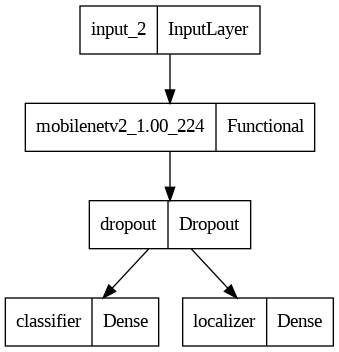

In [ ]:
# Use MobileNet as feature extractor
mobile.trainable = False

# Add the classifier to MobileNet
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
class_outputs = tfkl.Dense(1, activation='sigmoid', name='classifier')(x)
box_outputs = tfkl.Dense(4, activation='sigmoid', name='localizer')(x)

# Connect input and output through the Model class
object_localization_model = tfk.Model(inputs=inputs, outputs=[class_outputs,box_outputs], name='object_localization_model')

# Compile the model
object_localization_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam())
object_localization_model.summary()
tfk.utils.plot_model(object_localization_model)

In [ ]:
object_localization_history = object_localization_model.fit(
    x = preprocess_input(train_images),
    y = [train_labels,train_boxes],
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(val_images), [val_labels,val_boxes]),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 17s 308ms/step - loss: 1.0214 - classifier_loss: 0.5422 - localizer_loss: 0.4793 - val_loss: 0.6609 - val_classifier_loss: 0.2785 - val_localizer_loss: 0.3825 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 2s 159ms/step - loss: 0.6414 - classifier_loss: 0.2512 - localizer_loss: 0.3902 - val_loss: 0.5158 - val_classifier_loss: 0.1522 - val_localizer_loss: 0.3636 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 3s 170ms/step - loss: 0.5302 - classifier_loss: 0.1605 - localizer_loss: 0.3698 - val_loss: 0.4591 - val_classifier_loss: 0.1138 - val_localizer_loss: 0.3453 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 2s 157ms/step - loss: 0.4804 - classifier_loss: 0.1210 - localizer_loss: 0.3593 - val_loss: 0.4353 - val_classifier_loss: 0.0961 - val_localizer_loss: 0.3392 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 2s 143ms/step - loss: 0.4530 - classifier_loss: 0.

In [ ]:
# Save the best model
object_localization_model.save('MultitaskCatDogLocalizer')
del object_localization_model

In [ ]:
# Re-load the model after transfer learning
object_localization_model = tfk.models.load_model('MultitaskCatDogLocalizer')
object_localization_model.summary()

Model: "object_localization_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 1280)                 2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 dropout (Dropout)           (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
                                                                                                  
 classifier (Dense)          (None, 1)                    1281      ['drop

In [ ]:
# Predict labels for the entire test set
predictions = object_localization_model.predict(preprocess_input(val_images), verbose=0)

Predictions Shape: (240,)
Accuracy: 0.9875
Precision: 0.9878
Recall: 0.9875
F1: 0.9875


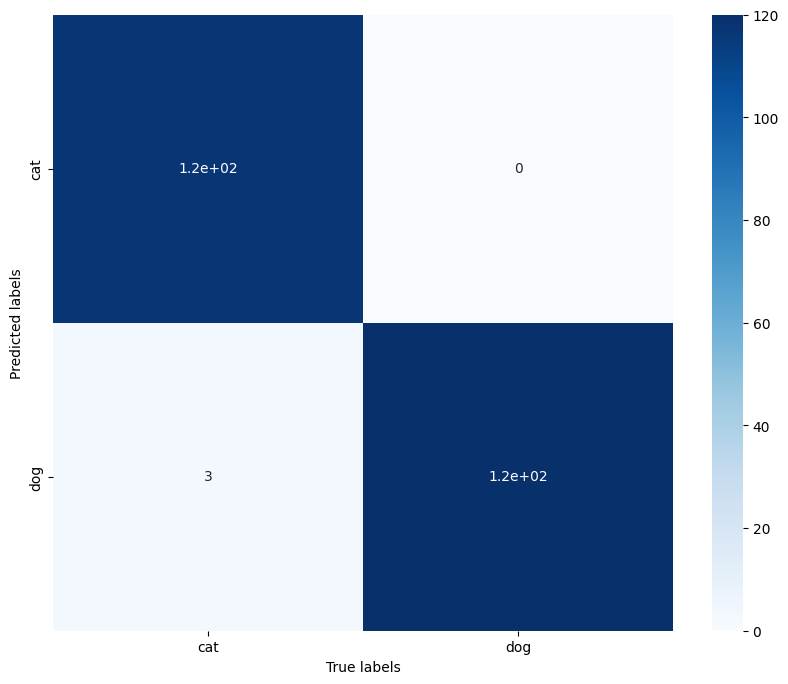

In [ ]:
classifier_predictions = np.array([int(i>.5) for i in predictions[0]])

# Display the shape of the predictions
print("Predictions Shape:", classifier_predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, classifier_predictions)
# Compute classification metrics
accuracy = accuracy_score(val_labels, classifier_predictions)
precision = precision_score(val_labels, classifier_predictions, average='macro')
recall = recall_score(val_labels, classifier_predictions, average='macro')
f1 = f1_score(val_labels, classifier_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(num_to_labels.values()), yticklabels=list(num_to_labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
box_predictions = predictions[1]
r2 = R2(val_boxes*256,box_predictions*256)
print(f'R^2: {r2}')

R^2: 0.9560216069221497


In [ ]:
test_path = 'localization_test/'
X_test = load_images_from_folder(test_path, 256)

In [ ]:
# Inspect the data
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(np.clip(X_test[i], 0, 255))
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_predictions = object_localization_model.predict(preprocess_input(X_test), verbose=0)

In [ ]:
# Inspect the predictions
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]


    # Bounding box of each image
    a1, b1, a2, b2 = test_predictions[1][i]
    img_size = 256

    # Rescaling the boundig box values to match the image size
    x1 = a1 * img_size
    x2 = a2 * img_size
    y1 = b1 * img_size
    y2 = b2 * img_size

    img = X_test[i].copy()

    # Draw bounding boxes on the image
    cv2.rectangle(img, (int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)

    if test_predictions[0][i]>0.5:
        confidence = round((test_predictions[0][i][0] - 0.5) * 200,1)
        label = 'dog'
    else:
        confidence = round((0.5 - test_predictions[0][i][0]) * 200,1)
        label = 'cat'

    ax.imshow(np.clip(img, 0, 255))
    ax.axis('off')
    ax.title.set_text('{}: {}%'.format(label, confidence))

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Double neural network

Image Classifier

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

In [ ]:
# Use MobileNet as feature extractor
mobile.trainable = False

# Add the classifier to MobileNet
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(2, activation='softmax', name='classifier')(x)

# Connect input and output through the Model class
classifier_model = tfk.Model(inputs=inputs, outputs=outputs, name='classifier_model')

# Compile the model
classifier_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
classifier_model.summary()

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 classifier (Dense)          (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
y_train_cat = tfk.utils.to_categorical(train_labels)
y_val_cat = tfk.utils.to_categorical(val_labels)

In [ ]:
# Train the model
classifier_history = classifier_model.fit(
    x = preprocess_input(train_images),
    y = y_train_cat,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(val_images), y_val_cat),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 7s 297ms/step - loss: 0.5816 - accuracy: 0.7260 - val_loss: 0.3392 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 2s 148ms/step - loss: 0.2901 - accuracy: 0.9427 - val_loss: 0.1853 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 2s 167ms/step - loss: 0.1808 - accuracy: 0.9677 - val_loss: 0.1320 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 2s 165ms/step - loss: 0.1381 - accuracy: 0.9740 - val_loss: 0.1083 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 2s 161ms/step - loss: 0.1115 - accuracy: 0.9740 - val_loss: 0.0978 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 2s 161ms/step - loss: 0.0922 - accuracy: 0.9854 - val_loss: 0.0904 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 2s 162ms/st

In [ ]:
# Save the best model
classifier_model.save('CatDogClassifier')
del classifier_model

In [ ]:
# Re-load the model after transfer learning
classifier_model = tfk.models.load_model('CatDogClassifier')
classifier_model.summary()

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 classifier (Dense)          (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
predictions = classifier_model.predict(preprocess_input(val_images), verbose=0)

Predictions Shape: (240,)
Accuracy: 0.9875
Precision: 0.9878
Recall: 0.9875
F1: 0.9875


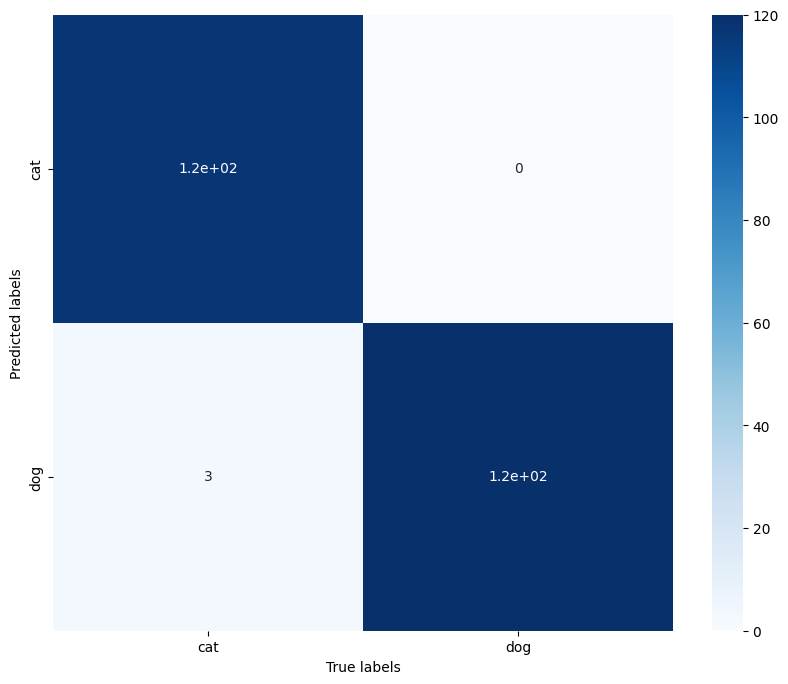

In [ ]:
# Display the shape of the predictions
print("Predictions Shape:", classifier_predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(val_labels, classifier_predictions)
# Compute classification metrics
accuracy = accuracy_score(val_labels, classifier_predictions)
precision = precision_score(val_labels, classifier_predictions, average='macro')
recall = recall_score(val_labels, classifier_predictions, average='macro')
f1 = f1_score(val_labels, classifier_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(num_to_labels.values()), yticklabels=list(num_to_labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Box Regressor

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape = train_images.shape[1:],
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg',
)

In [ ]:
# Use MobileNet as feature extractor
mobile.trainable = False

# Add the classifier to MobileNet
inputs = tfk.Input(shape=train_images.shape[1:])
x = mobile(inputs)
x = tfkl.Dropout(0.5, seed=seed)(x)
outputs = tfkl.Dense(4, activation='sigmoid', name='box_regressor')(x)

# Connect input and output through the Model class
box_regressor_model = tfk.Model(inputs=inputs, outputs=outputs, name='box_regressor_model')

# Compile the model
box_regressor_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())
box_regressor_model.summary()

Model: "box_regressor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 box_regressor (Dense)       (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Train the model
regressor_history = box_regressor_model.fit(
    x = preprocess_input(train_images),
    y = train_boxes,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(val_images), val_boxes),
    callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-5)
    ]
).history

Epoch 1/200
15/15 [==============================] - 7s 280ms/step - loss: 0.0591 - val_loss: 0.0154 - lr: 0.0010
Epoch 2/200
15/15 [==============================] - 2s 145ms/step - loss: 0.0165 - val_loss: 0.0172 - lr: 0.0010
Epoch 3/200
15/15 [==============================] - 2s 138ms/step - loss: 0.0169 - val_loss: 0.0172 - lr: 0.0010
Epoch 4/200
15/15 [==============================] - 2s 140ms/step - loss: 0.0166 - val_loss: 0.0167 - lr: 0.0010
Epoch 5/200
15/15 [==============================] - 2s 153ms/step - loss: 0.0162 - val_loss: 0.0160 - lr: 0.0010
Epoch 6/200
15/15 [==============================] - 2s 158ms/step - loss: 0.0160 - val_loss: 0.0154 - lr: 0.0010
Epoch 7/200
15/15 [==============================] - 3s 177ms/step - loss: 0.0155 - val_loss: 0.0149 - lr: 0.0010
Epoch 8/200
15/15 [==============================] - 2s 160ms/step - loss: 0.0152 - val_loss: 0.0146 - lr: 0.0010
Epoch 9/200
15/15 [==============================] - 3s 179ms/step - loss: 0.0148 - val_

In [ ]:
# Save the best model
box_regressor_model.save('CatDogBoxRegressor')
del box_regressor_model

In [ ]:
# Re-load the model after transfer learning
box_regressor_model = tfk.models.load_model('CatDogBoxRegressor')
box_regressor_model.summary()

Model: "box_regressor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 box_regressor (Dense)       (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
predictions = box_regressor_model.predict(preprocess_input(val_images), verbose=0)

In [ ]:
box_predictions = predictions
r2 = R2(val_boxes*256,box_predictions*256)
print(f'R^2: {r2}')

R^2: 0.957433819770813


Combine the models and test them together

In [ ]:
test_path = 'localization_test/'
X_test = load_images_from_folder(test_path,img_size)

In [ ]:
# Inspect the data
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(np.clip(X_test[i], 0, 255))
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_class_predictions = classifier_model.predict(preprocess_input(X_test), verbose=0)
test_box_predictions = box_regressor_model.predict(preprocess_input(X_test), verbose=0)

In [ ]:
# Inspect the predictions
num_images = 10
fig, axes = plt.subplots(2, num_images//2, figsize=(20, 9))

for i in range(num_images):
    ax = axes[i % 2, i % num_images//2]

    # Bounding box of each image
    x1, y1, x2, y2 = test_box_predictions[i]
    img_size = 256

    # Rescale the bounding box values to match the image size
    x1 *= img_size
    x2 *= img_size
    y1 *= img_size
    y2 *= img_size

    # Draw bounding boxes on the image
    img = X_test[i].copy()
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)

    # Set label and confidence level
    if test_class_predictions[i][1] > 0.5:
        confidence = round((test_class_predictions[i][1] - 0.5) * 200, 1)
        label = 'dog'
    else:
        confidence = round((0.5 - test_class_predictions[i][1]) * 200, 1)
        label = 'cat'

    # Display image and title
    ax.imshow(np.clip(img, 0, 255))
    ax.axis('off')
    ax.set_title(f'{label}: {confidence}%')

# Set overall title for the figure
fig.suptitle('Bounding box predictions', fontsize=16)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Class Activation Maps

In [ ]:
test_path = 'localization_test'
X_test = load_images_from_folder(test_path,img_size)
X_test_preprocessed = preprocess_input(X_test)

In [ ]:
def compute_CAM(model, img):
    # Expand image dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)

    # Predict to get the winning class
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Get the 1028 input weights to the softmax of the winning class
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Define the final convolutional layer of the MobileNetV2 model
    final_conv_layer = tfk.Model(
        model.get_layer('mobilenetv2_1.00_224').input,
        model.get_layer('mobilenetv2_1.00_224').get_layer('Conv_1').output
    )

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs and compute the final output using the class weights
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1)
    final_output = np.dot(mat_for_mult.reshape((256*256, 1280)), class_weights_winner).reshape(256,256)

    return final_output, label_index, predictions

In [ ]:
values = []
for img in X_test_preprocessed:
    values.append(compute_CAM(classifier_model, img))
values = np.array(values)

In [ ]:
# Inspect the data
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(values[i][0], cmap='turbo')
    ax.imshow(np.clip(X_test[i], 0, 255), alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):

    heatmap_max = np.max(values[i][0])

    boundary = heatmap_max * 0.3

    bbox_heatmap = values[i][0].copy()
    bbox_heatmap = np.where(bbox_heatmap <= boundary, 0, 255)

    bbox_img = X_test[i].copy()

    # find contours of heatmap
    cnts = cv2.findContours(bbox_heatmap.astype('uint8'),
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    offset = 10
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(bbox_img, (x+offset, y+offset),
                    (x+offset + w, y + h), (100,255,0), 3)


    label = num_to_labels[values[i][1]]
    confidence = round(values[i][2][0][values[i][1]] * 100,1)

    ax = axes[i%2,i%num_img//2]
    ax.imshow(np.clip(bbox_img, 0, 255))
    ax.title.set_text('{}: {}%'.format(label, confidence))
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.